### 회귀(값 맞추기)에서 분류(종류 맞추기)로 넘거가기

회귀와 분류는 비슷해보이지만 딥러닝에서는 가장 마지막의 출력과 Loss ftn 을 어떻게 사용하는지에 따라 미묘하게 다르다, 그 차이를 상세한 예를 들어서 설명해보기 위해 아래 코드를 예제로 만들었다

먼저 가장 흔하게 사용하는 MNIST 손글씨 데이터를 로드한다. Keras 페키지에 자동으로 포함되어 있으므로, 단순히 keras.datasets.mnist.load_data 를 실행하는 것 만으로도 데이터가 로드된다. 데이터는 기본적으로 28 * 28 pixel에 쓰여진 숫자들이다.

In [137]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt


# Model / data parameters
num_classes = 10
input_shape = (28,28, 1)

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()


이 중에서 가장 쉬운 예를 위해서 숫자 "8" 과 "9" 만 따로 분류하는 예제를 들어설명한다.

먼저 데이터중에서 8과 9만을 발라내기 위해 아래 코드를 실행하면, x_train, x_test 에는 각각 8또는 9에 대한 이미지 데이터가
그리고 y_train, y_test 에는 그 이미지 데이터에 해당하는 숫자 정보가 들어간다.

In [138]:
eight_nine_idx = (y_train == 8) | (y_train == 9)
x_train = x_train[eight_nine_idx]
y_train = y_train[eight_nine_idx]

eight_nine_idx_test = (y_test == 8) | (y_test == 9)
x_test = x_test[eight_nine_idx_test]
y_test = y_test[eight_nine_idx_test]

테스트로 하나를 찍어보면 아래와 같이 9라는 손글씨 이미지와, 실제 9라는 정답지가 같이 나온다.

9


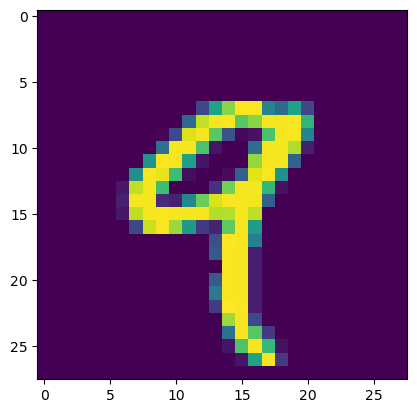

In [139]:
plt.imshow(x_train[0])
print(y_train[0])

이제 8 과 9 를 분류하기 위해 가장 쉬운방법을 생각해보자. 가장 간단한 접근방법은 이미지를 상하로 나누었을때, 위쪽과 아래쪽이 비슷하면 8, 위보다 아래가 작으면 9 라고 판단하는 것일 것이다. 다만 이렇게 완전히 반으로 (0~13행) (14~28행) 딱 나누었을 때에, 손글시가 완전히 가운데 쓰였다는 보장이 없을 수 있기 때문에 (다소간 위, 아래로 shift가 발생할 수 있으므로) 아래와 같이 두개의 선을 긋고 그 선에 걸친 숫자를 비교해서 비슷하면 8, 위가 아래보다 크면 9 라고 추측하는 함수를 정의했다.

![Alt text](image.png)

In [140]:
def guess(image_data):
    upper_side = image_data[10, :].mean()
    lower_side = image_data[20, :].mean()

    if upper_side > lower_side * 1.2: # 상하로 선을 그어서 그 선에 걸친 숫자들의 평균이 위가 아래보다 20% 이상 더 크면 9 
        return 9
    else: # 비슷하거나 작으면 8 
        return 8

급조한 분류기 이지만, 대략 얼추 돌아갈 것 같다. 처음 10개에 대해서 실제로 우리의 8/9 분류기가 돌아가는 테스트해보자

9


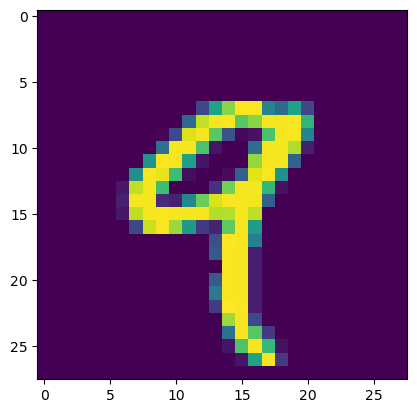

8


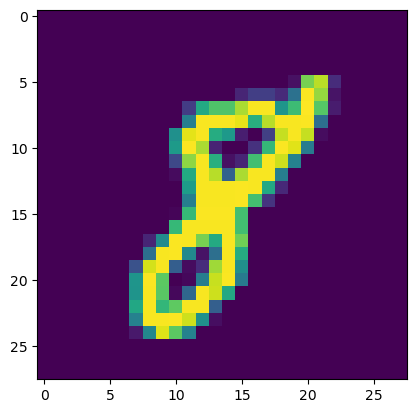

9


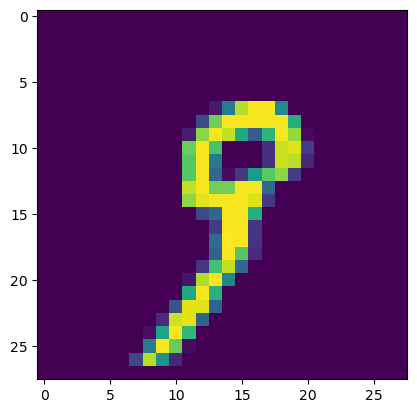

9


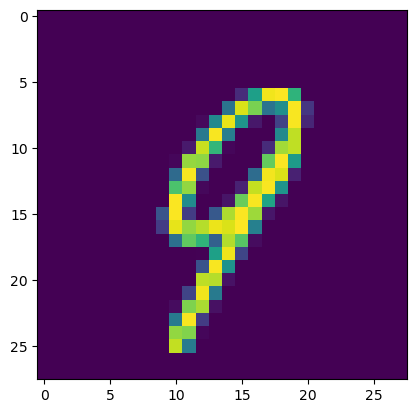

9


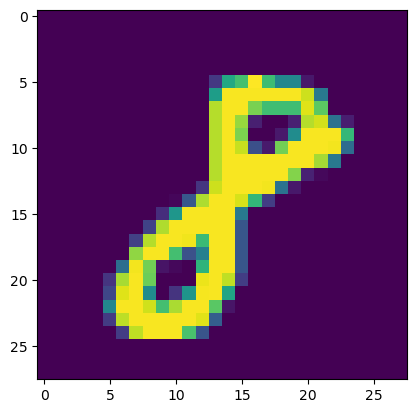

9


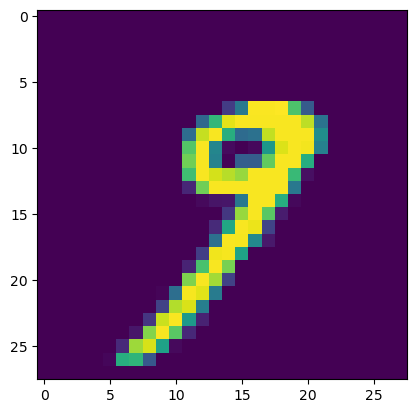

8


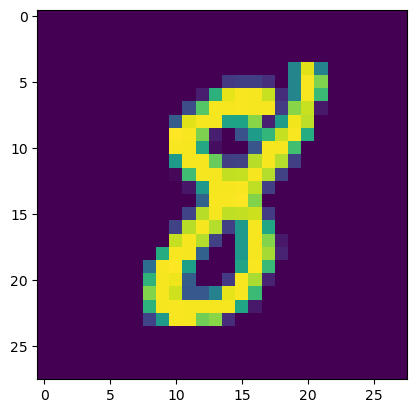

9


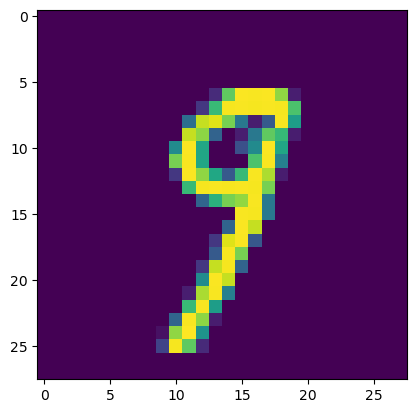

9


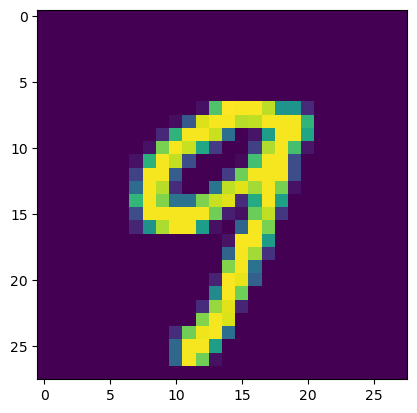

8


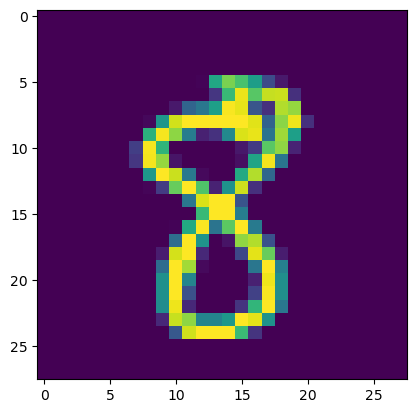

In [141]:

for i in range(10):
    plt.imshow(x_train[i])
    print( guess(x_train[i]))
    plt.show()

반타작 보다는 좀 더 좋은 성능인거 같다. 그럼 test set에 대해서 정분류율(accuracy)를 계산해보자

In [142]:
correct = wrong = 0
for i in range(len(y_test)):
    data = x_test[i]
    predicted_value = guess(data)
    if predicted_value == y_test[i]:
        correct = correct +1
    else :
        wrong = wrong + 1

맞춘 걸 Correct, 틀린 걸 Wrong으로 카운트해서 전체의 비율을 보면 

In [143]:
accuracy = (correct) / (correct + wrong) * 100
print(accuracy)

74.5839636913767


75% 정도의 정분유율이 나온다. 간단한 O/X 문제에서 완전한 반타작이 50% 라고 생각하면, 이에 대한 성능향상이 25%p 정도니 나름 분류하려고 노력은 했다고 할 수 있다. 아마 전체 28x28 이미지에서 단순히 2개의 선이 아니라 여러개의 선을 긋는 식으로 접근했으면 성능이 좀 더 향상했을지도 모른다. 

이번에는 딥러닝을 활용한 방법으로 접근해보자. 통상 Deep learning 에서는 각 node - weight 수준을 비슷하게 맞추기 위해서 Min-Max scaling을 하기 때문에 비슷하게 0~1로 처리했다. (최대값이 255 이므로 255로 나눠줌)

In [144]:
# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


x_train shape: (11800, 28, 28)
11800 train samples
1983 test samples


모델을 간단하게 만들었다. 제일 간단하게 64개의 feature 만으로 분류해보자. 1개 층으로도 간단하겠지만, DEEP! learning을 공부하고 있으니 중간에 hidden layer도 괜히 하나 추가해주자! (처음 feature는 우리가 손으로 만든 것 같은 64개의 선을 긋는다고 생각), 최종 출력단은 8 또는 9라는 숫자가 나와야 하므로 1개의 숫자를 출력하게 Dense(1) 로 연결해주었다. 

In [199]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Flatten(),
        layers.Dense(64),
        layers.Dense(32, activation='relu'),
        layers.Dense(1),
    ]
)

model.summary()

Model: "sequential_27"


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_27 (Flatten)        (None, 784)               0         
                                                                 
 dense_89 (Dense)            (None, 64)                50240     
                                                                 
 dense_90 (Dense)            (None, 32)                2080      
                                                                 
 dense_91 (Dense)            (None, 1)                 33        
                                                                 
Total params: 52353 (204.50 KB)
Trainable params: 52353 (204.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


그리고 모델을 컴파일한다. 로스는 mean square error 정도로 해도 될 것 같다. (정답을 맞추면 0, 틀리면 1이므로)

기억할 것은 딥러닝은 학습을 진행하면서 이 loss 라고 정의된 함수를 낮추도록 weight 를 변화시킬 뿐, 그 loss의 의미따위는 중요하지 않다. 따라서 내가 제대로 계산했을때 작고, 뭔가 제대로 계산 못했을 때 커지기만 한다면 어떤 값이라도 (설령 log를 취하거나, 제곱을 취하거나, 절대값을 취하는 등을 해도) 상관없다.

옵티마이져는 모르면 '아담'을 써라라는 말이 있다고 했다. 우리는 잘 모르니까 adam을 쓴다. 20회 학습을 돌려보자

In [200]:
batch_size = 128
epochs = 20

model.compile(loss='mse', optimizer='adam')
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/20
83/83 [==============================] - 0s 2ms/step - loss: 7.2379 - val_loss: 3.0613
Epoch 2/20
83/83 [==============================] - 0s 1ms/step - loss: 2.6279 - val_loss: 2.4295
Epoch 3/20
83/83 [==============================] - 0s 1ms/step - loss: 1.9609 - val_loss: 1.8358
Epoch 4/20
83/83 [==============================] - 0s 1ms/step - loss: 1.4338 - val_loss: 1.2758
Epoch 5/20
83/83 [==============================] - 0s 1ms/step - loss: 1.0508 - val_loss: 0.9549
Epoch 6/20
83/83 [==============================] - 0s 1ms/step - loss: 0.7518 - val_loss: 0.7141
Epoch 7/20
83/83 [==============================] - 0s 1ms/step - loss: 0.5049 - val_loss: 0.4511
Epoch 8/20
83/83 [==============================] - 0s 1ms/step - loss: 0.3149 - val_loss: 0.2845
Epoch 9/20
83/83 [==============================] - 0s 1ms/step - loss: 0.1937 - val_loss: 0.1695
Epoch 10/20
83/83 [==============================] - 0s 2ms/step - loss: 0.1131 - val_loss: 0.1128
Epoch 11/20
83/83 [

실제 돌려보니 학습 결과가 나쁘지 않아 보인다. (loss 가 상당히 줄어들고 있다.) 이제 이 모델로 학습을 시키지 않은 test에 대해 정합성을 확인해보자

In [204]:
predicted_value = model.predict(x_test)

62/62 [==============================] - 0s 464us/step


이 predicted_value는 모델에 이미지를 넣었을 때 자신이 생각하는 정답을 8또는 9에 가깝게(loss가 적게) 출력한 값이다. MSE(mean square error) 라는 로스는 (예측값 - 실제값)^2 이므로 8이라고 생각하면 8에 가까운 수를, 9라고 생각하면 9에 가까운 수가 나오게 학습했을 것이다. 

예를 들어

8.1 ==> 8이라고 생각함

8.9 ==> 9라고 생각함 

같은 느낌이다. 이걸 실제 분류 (둘 중 하나) 하기 위해서 제일 쉬운 방법은 반올림이다! 

In [205]:
predicted_value

array([[9.016472],
       [9.0628  ],
       [9.050027],
       ...,
       [9.042522],
       [8.104597],
       [9.109284]], dtype=float32)

반올림을 한 뒤에 실제 정답지와 맞춰보자! 

In [202]:
correct = wrong = 0
for i in range(len(y_test)):
    if y_test[i] == round(predicted_value[i][0]):
        correct = correct+1
    else:
        wrong = wrong + 1


In [203]:
accuracy = (correct) / (correct + wrong) * 100
print(accuracy)

98.03328290468987


놀랍게도 98%에 가까운 정답율을 보여준다.. 세상에..

어떤게 틀렸는지 궁금하니 여기까지 확인해보자

In [206]:
wrong_index = []
for i in range(len(y_test)):
    if y_test[i] != round(predicted_value[i][0]):
        wrong_index.append(i)

real : 8    predicted : 9


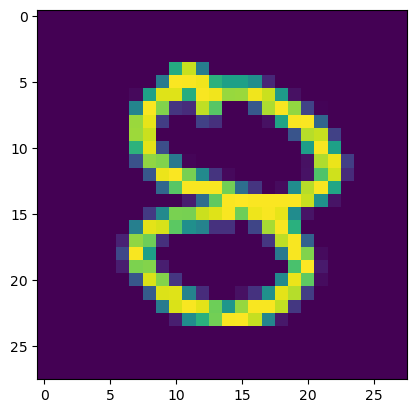

real : 8    predicted : 9


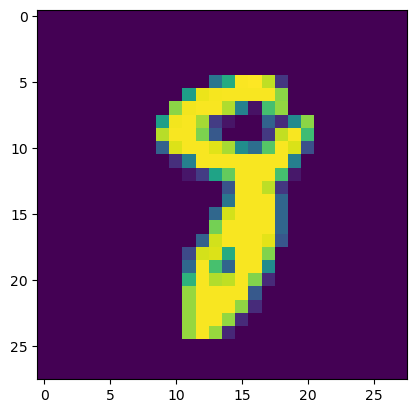

real : 9    predicted : 8


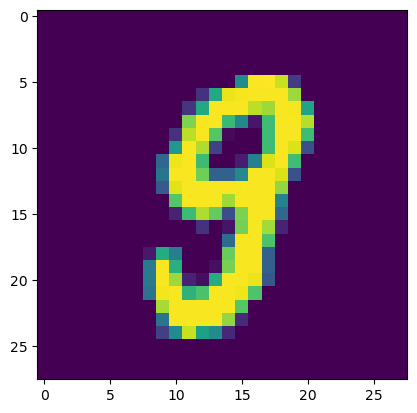

real : 8    predicted : 9


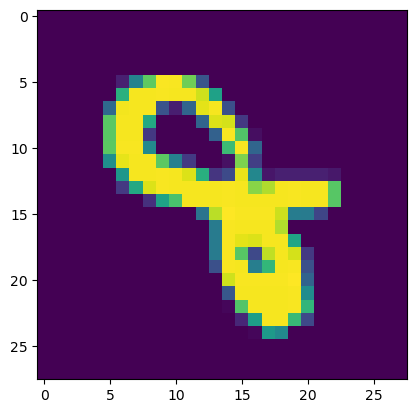

real : 8    predicted : 9


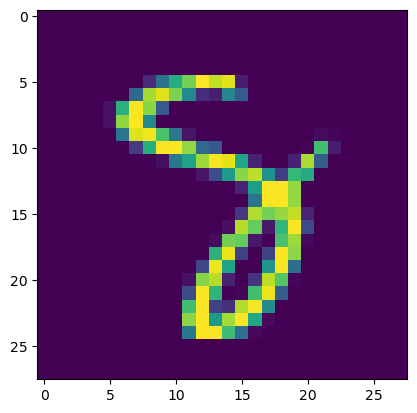

real : 8    predicted : 9


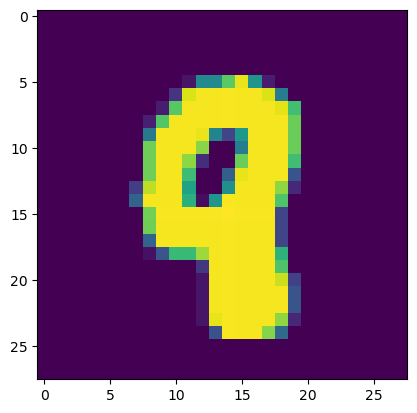

real : 8    predicted : 9


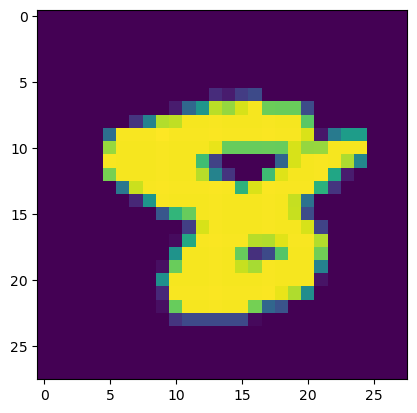

real : 9    predicted : 8


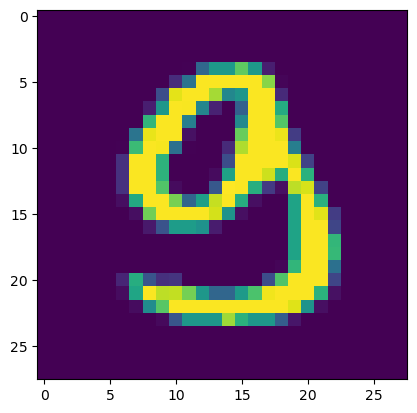

real : 9    predicted : 8


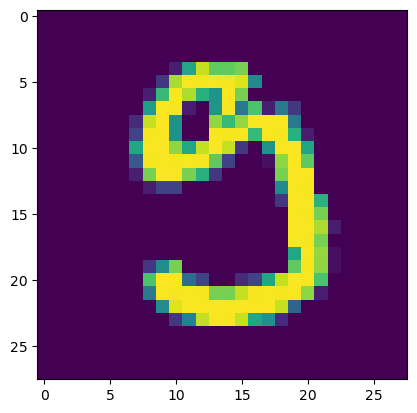

real : 8    predicted : 9


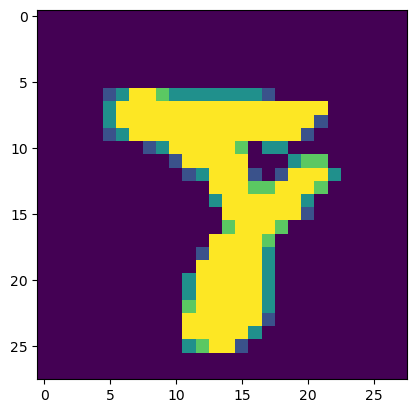

In [213]:
for i in range(10):
    idx = wrong_index[i]
    print("real :", y_test[idx],  "   predicted :", round(predicted_value[idx][0]))
    plt.imshow(x_test[idx])
    plt.show()

대부분 악필이었던거 같다... 아마도 저런 필체는 트레인에서는 잘 나타나는 형태가 아니었기 때문에, 오분류가 났을 가능성이 높다.